In [9]:
#from utils import read_canonical_model, load_pc
# import autograd.numpy as np
#import utils
import numpy as np
from copy import deepcopy
import os
os.chdir("/home/mushaikh/private/PointCloudPosePrediction")
from utils.utils import invert_pose
import importlib
import yaml
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import transforms3d as t3d
from transforms3d.quaternions import mat2quat
import transforms3d.quaternions as tq
import transforms3d.axangles as ax
# from autograd import grad
from numpy.linalg import norm
from scipy.spatial.transform import Rotation as R
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import dgl.geometry
import numpy as np
# from .utils import read_canonical_model, load_pc, visualize_icp_result
# from icp_file import icp
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
import torch
import core.pointnet as pnet
importlib.reload(pnet)
import utils.dataloader
import utils.utils
import utils.vision
importlib.reload(utils.utils)
importlib.reload(utils.vision)
importlib.reload(utils.dataloader)
import scipy.io as sio
import open3d as o3d
import cv2


def visualize_icp_result(source_pc, target_pc, pose):
  '''
  Visualize the result of ICP
  source_pc: numpy array, (N, 3)
  target_pc: numpy array, (N, 3)
  pose: SE(4) numpy array, (4, 4)
  '''
  source_pcd = o3d.geometry.PointCloud()
  source_pcd.points = o3d.utility.Vector3dVector(source_pc.reshape(-1, 3))
  source_pcd.paint_uniform_color([0, 1, 1])

  target_pcd = o3d.geometry.PointCloud()
  target_pcd.points = o3d.utility.Vector3dVector(target_pc.reshape(-1, 3))
  target_pcd.paint_uniform_color([1, 0, 0])

  source_pcd.transform(pose)
  #target_pcd.transform(np.linalg.inv(pose))

  o3d.visualization.draw_geometries([source_pcd, target_pcd])

# with open("./models/run_1.yaml") as f:
#     params = yaml.safe_load(f)

    
dataset= utils.dataloader.EdenDataset("/home/mushaikh/private/sample",
#                                             train=True,
#                                             use_keypt_downsample = True,
                                            keypt_method="random",#params['keypoint_detection']['detection_method']
                                           pcd_num_pts=20000# pcd_num_pts=params['keypoint_detection']['pcd_num_pts']
                                            )

# edenLoader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (/opt/conda/lib/python3.9/site-packages/typing_extensions.py)

In [6]:
pose = dataset[0]['pose']
visualize_icp_result(dataset[0]['pcd1'], dataset[0]['pcd2'], invert_pose(pose))

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [23]:
positions = np.zeros((500, 3))
for j in range(100):
    positions[j] = invert_pose(dataset[j]['pose'])[:3,3] # ground truth poses 

In [131]:
# get pt clouds from open3d library

0
Rel Pose from ICP [[ 1.00000002e+00 -2.64639460e-05 -4.52836440e-05  2.11443093e-05]
 [ 2.63724629e-05  9.99999933e-01  2.12384003e-04  1.94850322e-05]
 [ 4.52499499e-05 -2.12369619e-04  9.99999976e-01  2.62390905e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Initialization angle to ICP:  -5.2429310646979474e-08
ICP output angle 0.0002178182519920387
    
Translation initialization to ICP:  [0. 0. 0.]
ICP translation output:  [2.11443093e-05 1.94850322e-05 2.62390905e-06]
1
Rel Pose from ICP [[ 1.00000002e+00 -5.05475348e-08 -1.40474425e-08  3.83029962e+01]
 [-5.05475348e-08  9.99999955e-01  7.78660296e-09 -3.21389933e+01]
 [-1.40474425e-08  7.78660296e-09  1.00000000e+00 -1.95004635e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Initialization angle to ICP:  -5.2429310646979474e-08
ICP output angle -5.2429310646979474e-08
    
Translation initialization to ICP:  [ 38.30299618 -32.13899325  -0.19500463]
ICP translation output:  [ 3

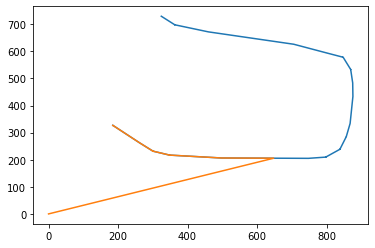

In [138]:
# ICP with ground truth

batch_size = 64 # number of times stamps
poses = np.zeros((4, 4, batch_size))
poses[:, :, 0] = invert_pose(dataset[0]['pose']) # Pose of the robot in body frame at time t = 0
poses[:, :, 0][:3, 3] = poses[:, :, 0][:3, 3] * 100

error_p = np.zeros(batch_size)
error_R = np.zeros(batch_size)

source = o3d.geometry.PointCloud()
target = o3d.geometry.PointCloud()

threshold = 0.02 # thresholf for ICP
for i in range(batch_size - 1):
    
    print(i)
    
    
    source.points = o3d.utility.Vector3dVector(dataset[i]['pcd1'].numpy())
    target.points = o3d.utility.Vector3dVector(dataset[i]['pcd2'].numpy())
    
    
    trans_init = dataset[i]['rel_pose'].numpy()
    trans_init[:3, 3] = dataset[i]['rel_pose'][:3, 3].numpy() * 100
        

    
    reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
    print("Rel Pose from ICP", reg_p2p.transformation)
    
    
    
    
#     source = np.transpose(dataset[i]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd1'].numpy() - dataset[i]['pose'][:3, 3].numpy()).T
#     target = np.transpose(dataset[i + 1]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd2'].numpy() - dataset[i + 1]['pose'][:3, 3].numpy()).T
    
    # initialize
#     p_initial = dataset[i]['translation'].numpy() 
#     R_initial = R.from_quat(dataset[i]['quat']) # Rotation between t+1 and t
    
    #pose_initial = icp(5, target, source, np.eye(3), p_initial) # get initial rotation
    
    # Run ICP to get the pose at the next time step t_T_t+1
#     rel_pose, _ = icp(iters, target, source, dataset[i]['rel_pose'][0:3, 0:3], dataset[i]['rel_pose'][:3, 3])
    
#     R_rel = rel_pose[0:3, 0:3] # relative rotation from icp
#     p_rel = rel_pose[:3, 3] # relative translation from icp
    
    error_p[i] = np.linalg.norm(reg_p2p.transformation[:3, 3] - trans_init[:3, 3])
    error_R[i] = ax.mat2axangle(np.matmul(trans_init[0:3, 0:3].T, reg_p2p.transformation[0:3, 0:3]))[1]
    

    
    
    print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
    print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
    
    print("    ")
#     print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
    print("Translation initialization to ICP: ", trans_init[:3, 3])
    
#     print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
    print("ICP translation output: ", reg_p2p.transformation[:3, 3])
    
    if i == 15:
        break

    #estimate pose at the next time step
    poses[:, :, i + 1] = np.matmul(reg_p2p.transformation, poses[:, :, i]) # world to body pose
    
    
    
#     #Update
#     prev_rel_pose = reg_p2p.transformation # relative pose estimated by ICP
plt.plot(positions[:batch_size,0] * 100,positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

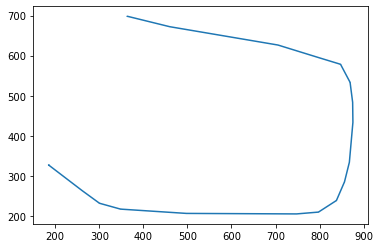

In [361]:
# plt.plot(positions[:batch_size,0] * 100,positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

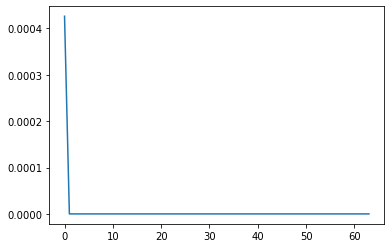

In [363]:
# plt.plot(error_R)
plt.plot(error_p)
plt.show()

In [57]:
dataset[54]['pose']

tensor([[-8.7852e-01,  4.7771e-01,  4.0847e-08,  1.7796e+00],
        [-4.0847e-08, -1.1115e-07, -1.0000e+00,  5.0160e-01],
        [-4.7771e-01, -8.7852e-01, -1.1115e-07,  8.4094e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [58]:
dataset[55]['pose']

tensor([[-8.7852e-01,  4.7771e-01,  4.0847e-08,  1.3040e+00],
        [-4.0847e-08, -1.1115e-07, -1.0000e+00,  5.0000e-01],
        [-4.7771e-01, -8.7852e-01, -1.1115e-07,  8.2549e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [59]:
np.dot(utils.utils.invert_pose(dataset[55]['pose']), dataset[54]['pose'])

array([[ 9.99999559e-01,  5.69479336e-08,  5.80596214e-08,
        -4.91569875e-01],
       [ 5.69479336e-08,  9.99999768e-01,  2.28307959e-07,
         9.14294366e-02],
       [ 5.80596214e-08,  2.28307959e-07,  9.99999762e-01,
        -1.60002464e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [60]:
new_pose = dataset[55]['rel_pose']
new_pose[:3, 3] = dataset[55]['rel_pose'][:3, 3] 
visualize_icp_result(dataset[55]['pcd1'], dataset[55]['pcd2'], invert_pose(new_pose))

0
10
20
30
40
50
60


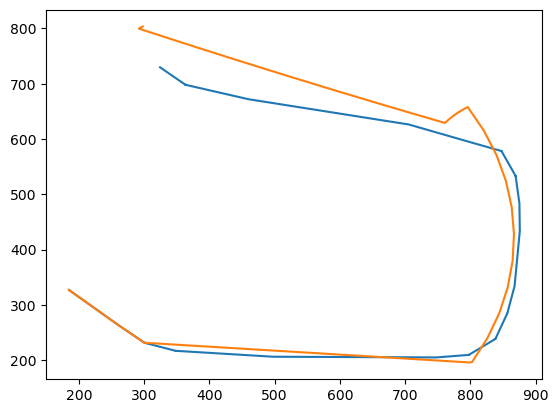

In [45]:
# visualize the trajectory of a sequence

batch_size = 64 # number of times stamps
iters = 100
poses = np.zeros((4, 4, batch_size))
poses[:, :, 0] = invert_pose(dataset[0]['pose']) # Pose of the robot in body frame at time t = 0
poses[:, :, 0][:3, 3] = poses[:, :, 0][:3, 3] * 100


error_p = np.zeros(batch_size)
error_R = np.zeros(batch_size)

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize

source = o3d.geometry.PointCloud()
target = o3d.geometry.PointCloud()

threshold = 0.02 # thresholf for ICP
for i in range(batch_size - 1):

    if i % 10 == 0:
        print(i)

    
    source.points = o3d.utility.Vector3dVector(dataset[i]['pcd1'].numpy())
    target.points = o3d.utility.Vector3dVector(dataset[i]['pcd2'].numpy())
    
    
#     trans_init = np.eye(4)
    
    if i < 5 or i % 10 == 0: # at the beginning I only have ground truth rel pose
        trans_init = dataset[i]['rel_pose'].numpy()
#         trans_init[:3, 3] = dataset[i]['rel_pose'][:3, 3].numpy() * 100
#         trans_init = np.eye(4)
        trans_init[0, 3] =  dataset[i]['rel_pose'][0, 3].numpy() * 100
        trans_init[1, 3] =  dataset[i]['rel_pose'][1, 3].numpy() * 100

    else:
        trans_init = deepcopy(reg_p2p.transformation) # assumes model continuity , initialize ICP with prev rel pose
#         print(trans_init)
#         trans_init[:3, 3] = trans_init[:3, 3] * 100
#         trans_init = dataset[i]['rel_pose'].numpy() * 100

    
        
        
    
    reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint # run ICPs
#     print(reg_p2p.transformation)
        
    
#     source = np.transpose(dataset[i]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd1'].numpy() - dataset[i]['pose'][:3, 3].numpy()).T
#     target = np.transpose(dataset[i + 1]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd2'].numpy() - dataset[i + 1]['pose'][:3, 3].numpy()).T
    
    # initialize
#     p_initial = dataset[i]['translation'].numpy() 
#     R_initial = R.from_quat(dataset[i]['quat']) # Rotation between t+1 and t
    
    #pose_initial = icp(5, target, source, np.eye(3), p_initial) # get initial rotation
    
    # Run ICP to get the pose at the next time step t_T_t+1
#     rel_pose, _ = icp(iters, target, source, dataset[i]['rel_pose'][0:3, 0:3], dataset[i]['rel_pose'][:3, 3])
    
#     R_rel = rel_pose[0:3, 0:3] # relative rotation from icp
#     p_rel = rel_pose[:3, 3] # relative translation from icp
    
#     error_p[i] = np.linalg.norm(p_rel - dataset[i]['rel_pose'].numpy()[:3, 3])
#     error_R[i] = ax.mat2axangle(np.matmul(R_rel, dataset[i]['rel_pose'][0:3, 0:3]))[1]

        
#     print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
#     print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
    
#     print("    ")
# #     print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
#     print("Translation initialization to ICP: ", trans_init[:3, 3])
    
# #     print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
#     print("ICP translation output: ", reg_p2p.transformation[:3, 3])
    
#     print("")
    
#     if i == 50:
    
#         break

    #estimate pose at the next time step
    poses[:, :, i + 1] = np.matmul(reg_p2p.transformation, poses[:, :, i]) # world to body pose
#     poses[:, :, i + 1] = np.matmul(poses[:, :, i], reg_p2p.transformation) # world to body pose
    
    
    
    #Update
#     prev_rel_pose = reg_p2p.transformation # relative pose estimated by ICP
    

# Invert poses for plotting purposes
# for i in range(64):
#     poses[:, :, i] = invert_pose(poses[:, :, i])




plt.plot(positions[:batch_size,0] * 100, positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

In [46]:
# get pose estimates and ground truths in correct data format

mat_est = np.zeros((64, 8))
mat_gt = np.zeros((64, 8))
for i in range(batch_size):


    mat_est[i, :] = np.append(i, np.append(poses[:, :, i][:3, 3], mat2quat(poses[:, :, i][0:3, 0:3])[::-1]))
    mat_gt[i, :] = np.append(i, np.append(invert_pose(dataset[i]['pose'])[:3, 3] * 100, mat2quat(invert_pose(dataset[i]['pose'])[0:3, 0:3])))
    



filename_est = 'rpg_trajectory_evaluation/results/plotting_test/stamped_traj_estimate.txt'
filename_gt = 'rpg_trajectory_evaluation/results/plotting_test/stamped_groundtruth.txt'

# Save the matrix to the text file with the desired format
np.savetxt(filename_est, mat_est, fmt='%.10e', delimiter=' ')
np.savetxt(filename_gt, mat_gt, fmt='%.10e', delimiter=' ')

In [ ]:
# run evo_traj 
!evo_traj tum rpg_trajectory_evaluation/results/plotting_test/stamped_traj_estimate.txt --ref=rpg_trajectory_evaluation/results/plotting_test/stamped_groundtruth.txt -p --plot_mode=xy

In [ ]:
# run evo_res for tables, histograms
!evo_res test_tum.zip -p --save_table ./table.csv